## Prediction Model with Prophet

In [63]:
# import common 
import sys
sys.path.append('../common/')
from functions import get_view_counts

# import libraries
import pandas as pd
import numpy as np

from pymongo import MongoClient
from fbprophet import Prophet
from matplotlib import pyplot as plt
from matplotlib import dates as mdates

### Make a dataframe from mongodb

**Collections**
* video_detail : contains title, url, published date, video_id of video
* view_count : contains # of views, comments, likes

In [2]:
# connect mongodb through ssh tunnel
connection = MongoClient(port=47017)
db = connection['youtube_scrap']

### Load video detail to dataframe

In [3]:
# load from mongodb
video_coll = db['video_detail']
video_cur = video_coll.find({})
videos = [video for video in video_cur]

In [4]:
# select a video
video = videos[9]

In [5]:
# get view_counts for selected video
df = get_view_counts(db, video['video_id'])
df.head()

,_id,comment_count,like_count,timestamp,title,video_id,view_count
0,5d13b7a19ec6103a9817d75e,4495,183308,2019-06-26 18:21:16.925,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5505871
1,5d13c37b9ec6103a9817d89b,4497,183393,2019-06-26 19:11:51.844,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5509723
2,5d13c4779ec6103a9817d8af,4497,183397,2019-06-26 19:16:03.135,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5510424
3,5d13cdb89ec6103a9817d993,4498,183476,2019-06-26 19:55:32.016,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5514608
4,5d13d3ad9ec6103a9817da31,4501,183530,2019-06-26 20:20:57.911,Dream Glow (BTS World Original Soundtrack),HwT9oKqfUxY,5517267


### Make a prediction with Prophet

In [15]:
# initialize Prophet model
m = Prophet()

In [16]:
# prepare dataframe for Prophet
est_df = df[['timestamp', 'view_count']]
est_df.columns = ['ds', 'y']
est_df.head()

,ds,y
0,2019-06-26 18:21:16.925,5505871
1,2019-06-26 19:11:51.844,5509723
2,2019-06-26 19:16:03.135,5510424
3,2019-06-26 19:55:32.016,5514608
4,2019-06-26 20:20:57.911,5517267


In [17]:
# fit to model
m.fit(est_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/Users/teo/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [18]:
# make dataframe for estimatin after 3 days 
future = m.make_future_dataframe(periods=3)
future.tail()

,ds
416,2019-07-05 14:51:50.606
417,2019-07-05 15:16:36.260
418,2019-07-06 15:16:36.260
419,2019-07-07 15:16:36.260
420,2019-07-08 15:16:36.260


In [19]:
# perform predict 
forecast = m.predict(future)

In [20]:
# extracting some data
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
416,2019-07-05 14:51:50.606,6.226641e+06,6.225496e+06,6.227793e+06
417,2019-07-05 15:16:36.260,6.227383e+06,6.226304e+06,6.228468e+06
418,2019-07-06 15:16:36.260,6.279944e+06,6.257622e+06,6.302100e+06
419,2019-07-07 15:16:36.260,6.332504e+06,6.264677e+06,6.401154e+06
420,2019-07-08 15:16:36.260,6.385065e+06,6.252293e+06,6.513669e+06


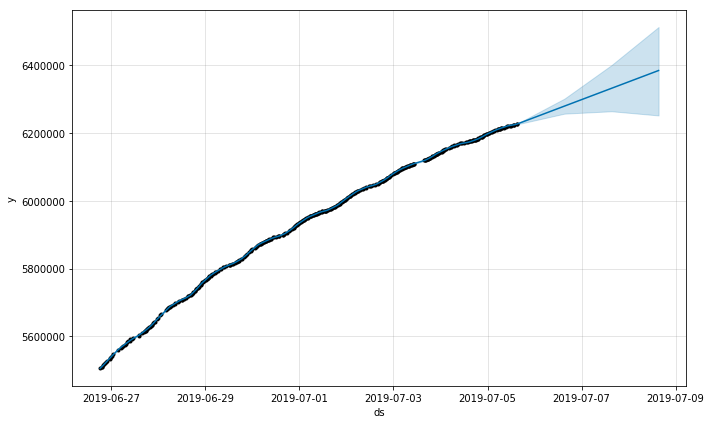

In [21]:
# Draw a chart with forecast (prophet function)
fig1 = m.plot(forecast)

### What's in the forecast

In [85]:
# extract last 3 rows in forecast 
# (but one more row is needed for chart)
df = forecast.tail(4)
df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
417,2019-07-05 15:16:36.260,6.230501e+06,6.226304e+06,6.228468e+06,6.230501e+06,6.230501e+06,-3118.106181,-3118.106181,-3118.106181,-3118.106181,-3118.106181,-3118.106181,0.0,0.0,0.0,6.227383e+06
418,2019-07-06 15:16:36.260,6.283062e+06,6.257622e+06,6.302100e+06,6.261055e+06,6.304883e+06,-3118.106181,-3118.106181,-3118.106181,-3118.106181,-3118.106181,-3118.106181,0.0,0.0,0.0,6.279944e+06
419,2019-07-07 15:16:36.260,6.335622e+06,6.264677e+06,6.401154e+06,6.268433e+06,6.404679e+06,-3118.106181,-3118.106181,-3118.106181,-3118.106181,-3118.106181,-3118.106181,0.0,0.0,0.0,6.332504e+06
420,2019-07-08 15:16:36.260,6.388183e+06,6.252293e+06,6.513669e+06,6.254768e+06,6.515821e+06,-3118.106181,-3118.106181,-3118.106181,-3118.106181,-3118.106181,-3118.106181,0.0,0.0,0.0,6.385065e+06


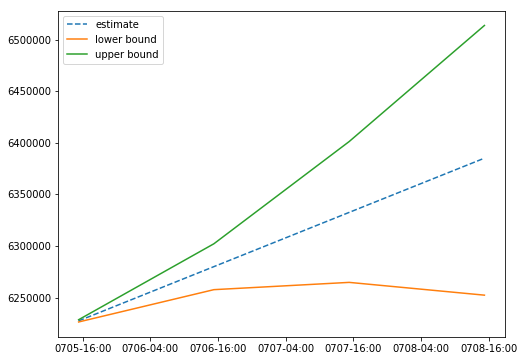

In [86]:
# Draw chart with 3 values in forecast
# yhat, yhat_upper, yhat_lower
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df['ds'], df['yhat'], '--', label='estimate')
ax.plot(df['ds'], df['yhat_lower'], '-', label='lower bound')
ax.plot(df['ds'], df['yhat_upper'], '-', label='upper bound')

hours = mdates.HourLocator(interval = 12)
h_fmt = mdates.DateFormatter('%m%d-%H:%M')

ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
plt.legend()
plt.show()

### Chart for past + forecast

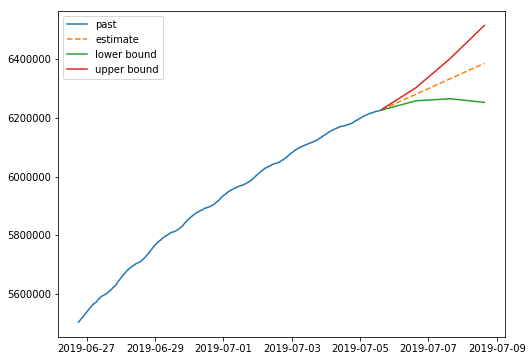

In [87]:
# Draw chart with 3 values in forecast
# yhat, yhat_upper, yhat_lower
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(est_df['ds'], est_df['y'], '-', label='past')

ax.plot(df['ds'], df['yhat'], '--', label='estimate')
ax.plot(df['ds'], df['yhat_lower'], '-', label='lower bound')
ax.plot(df['ds'], df['yhat_upper'], '-', label='upper bound')

# hours = mdates.HourLocator(interval = 24)
# h_fmt = mdates.DateFormatter('%m%d-%H:%M')

# ax.xaxis.set_major_locator(hours)
# ax.xaxis.set_major_formatter(h_fmt)
plt.legend()
plt.show()

### Accuracy of estimation

In [88]:
pass